IMPORT

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import TruncatedSVD,NMF,FactorAnalysis,KernelPCA,FastICA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import os 
import gc
import random
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

In [10]:
class CFG:
    folds=5
    seed=1
    train=False
    ver='git_'
    kfold='sk'
    model='lgb'
    n_components=10
    drop_col=[]
    cluster_num=4
    num_iterations=100000
def fix_seed(seed=CFG.seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
fix_seed()

In [11]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv('../data/test.csv')

In [12]:
def describe_satatistics(input_df):
    desc = pd.DataFrame(index=list(input_df))
    desc["nunique"] = train.nunique()
    desc["unique%"] = train.nunique() / len(input_df)
    desc["null"] = train.isnull().sum()
    desc["type"] = train.dtypes
    desc = pd.concat([desc,input_df.describe().T],axis=1)
    return desc

# Preprocessing

In [13]:
train_df = train.copy()
test_df = test.copy()

In [14]:
train["train_data"]=1
test["train_data"]=0
eda_df = pd.concat([train,test])
eda_df.reset_index(inplace=True,drop=True)

In [15]:
dataframe_list = [eda_df,train_df,test_df]

In [16]:
pd.set_option('display.max_columns', None)
eda_df.head()

,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,train_data
0,0,163,21,1.0,0,0,1,N,N,31-Jan-98,1.0,0,22-Sep-06,2006,PHOENIX,AZ,SD,"$80,000.00","$80,000.00","$68,000.00",0,1
1,1,84,6,1.0,4,0,0,0,N,31-Oct-93,1.0,62,30-Jun-92,1992,MCALESTER,OK,OK,"$287,000.00","$287,000.00","$229,600.00",0,1
2,2,242,45,1.0,4,90,0,N,N,31-Aug-01,1.0,42,18-Apr-01,2001,HAWTHORNE,NJ,NJ,"$31,983.00","$30,000.00","$15,000.00",1,1
3,3,237,4,1.0,0,0,0,N,N,31-Aug-07,1.0,33,6-Oct-03,2004,NASHVILLE,TN,SD,"$229,000.00","$229,000.00","$229,000.00",0,1
4,4,184,0,1.0,0,0,0,N,N,8-Jun-83,1.0,0,17-Dec-99,2000,POMONA,CA,CA,"$525,000.00","$525,000.00","$393,750.00",0,1


In [17]:
eda_df_02 = describe_satatistics(eda_df)

In [18]:
eda_df_02

,nunique,unique%,null,type,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,42307,0.499994,0,int64,84615.0,42307.000000,24426.390851,0.0,21153.5,42307.0,63460.5,84614.0
Term,228,0.002695,0,int64,84615.0,108.558447,84.731943,0.0,56.0,82.0,168.0,360.0
NoEmp,196,0.002316,0,int64,84615.0,9.699510,17.365667,0.0,2.0,4.0,12.0,208.0
NewExist,2,0.000024,0,float64,84615.0,1.209632,0.407048,1.0,1.0,1.0,1.0,2.0
CreateJob,49,0.000579,0,int64,84615.0,2.185144,5.112835,0.0,0.0,0.0,2.0,86.0
RetainedJob,83,0.000981,0,int64,84615.0,3.488897,8.124039,0.0,0.0,0.0,4.0,175.0
FranchiseCode,271,0.003203,0,int64,84615.0,1990.058843,10587.667836,0.0,0.0,0.0,1.0,90709.0
RevLineCr,4,0.000047,1079,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LowDoc,6,0.000071,531,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DisbursementDate,916,0.010826,150,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
def clean_date(input_df,col):
    input_df[col] = pd.to_datetime(input_df[col])
    return input_df

In [20]:
for c in dataframe_list:
    for a in ["DisbursementDate","ApprovalDate"]:
        c = clean_date(c,a)

C:\Users\kaminogo.kenji\AppData\Local\Temp\ipykernel_20596\2940027403.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  input_df[col] = pd.to_datetime(input_df[col])
C:\Users\kaminogo.kenji\AppData\Local\Temp\ipykernel_20596\2940027403.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  input_df[col] = pd.to_datetime(input_df[col])


C:\Users\kaminogo.kenji\AppData\Local\Temp\ipykernel_20596\2940027403.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  input_df[col] = pd.to_datetime(input_df[col])
C:\Users\kaminogo.kenji\AppData\Local\Temp\ipykernel_20596\2940027403.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  input_df[col] = pd.to_datetime(input_df[col])
C:\Users\kaminogo.kenji\AppData\Local\Temp\ipykernel_20596\2940027403.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  input_df[col] = pd.to_datetime(input_df[col])
C:\Users\kaminogo.kenji\AppData\Local\Temp\ipykernel_20596\2940027403.py:2: 

In [21]:
le = LabelEncoder()
label_columns_list = ["RevLineCr","LowDoc","City","State","BankState"]
def label_encode(input_df):
    for col in label_columns_list:
        le = LabelEncoder()
        le.fit(input_df[col])
        input_df[f"{col}_label"] = le.transform(input_df[col])
    return input_df


In [22]:
def clean_money(input_df):
    money_columns = ["DisbursementGross","GrAppv","SBA_Appv"]
    for col in money_columns:
        input_df[col] = input_df[col].str.replace('$', '').replace(',', '')
        input_df[col] = input_df[col].str.replace(",","")
        input_df[col] = input_df[col].str.extract(r"(\d+)")
        input_df[col] = input_df[col].astype(int)
    return input_df

In [23]:
def create_NoEmpLabel(input_df):
    input_df["NoEmp_label"] = 0
    input_df["NoEmp_label"] = np.where(input_df["NoEmp"]<3,1,input_df["NoEmp_label"])
    input_df["NoEmp_label"] = np.where((input_df["NoEmp"]>=3) & (input_df["NoEmp"]<5),2,input_df["NoEmp_label"])
    input_df["NoEmp_label"] = np.where((input_df["NoEmp"]>=5 )& (input_df["NoEmp"]<13),3,input_df["NoEmp_label"])
    input_df["NoEmp_label"] = np.where(input_df["NoEmp"]>=13,4,input_df["NoEmp_label"])
    print(input_df["NoEmp_label"].value_counts())
    return input_df

In [24]:
for c in dataframe_list:
    c = clean_money(c)
    c = label_encode(c)
    c = create_NoEmpLabel(c)

NoEmp_label
1    25873
2    20864
4    20698
3    17180
Name: count, dtype: int64
NoEmp_label
1    12945
2    10465
4    10332
3     8565
Name: count, dtype: int64
NoEmp_label
1    12928
2    10399
4    10366
3     8615
Name: count, dtype: int64


In [25]:
def create_main_key(input_df,column):
    tmp_df = input_df.copy()
    tmp_df[f"main_key_{column}"] = tmp_df[f"{column}"].astype(str).str.cat(tmp_df["Sector"].astype(str), sep="_")
    count_df =pd.DataFrame(tmp_df[f"main_key_{column}"].value_counts())
    count_df.reset_index(inplace = True)
    top_key_list = count_df[f"main_key_{column}"].head(100)
    input_df[f"main_key_{column}"] = input_df[f"{column}"].astype(str).str.cat(input_df["Sector"].astype(str), sep="_")
    input_df[f"main_key_{column}"] = np.where(input_df[f"main_key_{column}"].isin(top_key_list),input_df[f"main_key_{column}"],"XX")
    input_df[f"main_key_{column}"].value_counts()
    return input_df

In [26]:
main_key_list = []
for i,dataFrame in enumerate(dataframe_list):
    for col in ["NoEmp_label","State","City"]:
            dataFrame= create_main_key(dataFrame,col)
            if i == 0:
                main_key_list.append(f"main_key_{col}")
            print(col,"completed")

NoEmp_label completed
State completed
City completed
NoEmp_label completed
State completed
City completed
NoEmp_label completed
State completed
City completed


In [27]:
main_key_list

['main_key_NoEmp_label', 'main_key_State', 'main_key_City']

In [28]:
def create_groupby_features(input_df,target_col,group_feature):
    tmp_df =  input_df.groupby(group_feature)[target_col].agg(["median"])
    tmp_df.reset_index(inplace=True)
    tmp_df.rename(columns = {"median":f"{target_col}_{group_feature}_med"},inplace=True)
    if group_feature=='main_key':
        tmp_df[group_feature]=np.where(tmp_df[group_feature]=='XX','ZZZ',tmp_df[group_feature])
    input_df = pd.merge(input_df,tmp_df,how="left",on=group_feature)
    input_df[f"{target_col}_{group_feature}_diff"] = input_df[target_col] - input_df[f"{target_col}_{group_feature}_med"]
    print("completed")
    return input_df[[f"{target_col}_{group_feature}_med",f"{target_col}_{group_feature}_diff"]]

In [29]:
for c in dataframe_list:
    for key in main_key_list:
        for col in ["DisbursementGross","GrAppv","SBA_Appv","CreateJob","RetainedJob","NoEmp"]:
            c[[f"{col}_{key}_med",f"{col}_{key}_diff"]] = create_groupby_features(c,col,key)


completed


completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed


In [30]:
eda_df

,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,train_data,RevLineCr_label,LowDoc_label,City_label,State_label,BankState_label,NoEmp_label,main_key_NoEmp_label,main_key_State,main_key_City,DisbursementGross_main_key_NoEmp_label_med,DisbursementGross_main_key_NoEmp_label_diff,GrAppv_main_key_NoEmp_label_med,GrAppv_main_key_NoEmp_label_diff,SBA_Appv_main_key_NoEmp_label_med,SBA_Appv_main_key_NoEmp_label_diff,CreateJob_main_key_NoEmp_label_med,CreateJob_main_key_NoEmp_label_diff,RetainedJob_main_key_NoEmp_label_med,RetainedJob_main_key_NoEmp_label_diff,NoEmp_main_key_NoEmp_label_med,NoEmp_main_key_NoEmp_label_diff,DisbursementGross_main_key_State_med,DisbursementGross_main_key_State_diff,GrAppv_main_key_State_med,GrAppv_main_key_State_diff,SBA_Appv_main_key_State_med,SBA_Appv_main_key_State_diff,CreateJob_main_key_State_med,CreateJob_main_key_State_diff,RetainedJob_main_key_State_med,RetainedJob_main_key_State_diff,NoEmp_main_key_State_med,NoEmp_main_key_State_diff,DisbursementGross_main_key_City_med,DisbursementGross_main_key_City_diff,GrAppv_main_key_City_med,GrAppv_main_key_City_diff,SBA_Appv_main_key_City_med,SBA_Appv_main_key_City_diff,CreateJob_main_key_City_med,CreateJob_main_key_City_diff,RetainedJob_main_key_City_med,RetainedJob_main_key_City_diff,NoEmp_main_key_City_med,NoEmp_main_key_City_diff
0,0,163,21,1.0,0,0,1,N,N,1998-01-31,1.0,0,2006-09-22,2006,PHOENIX,AZ,SD,80000,80000,68000,0,1,1,3,2208,3,42,4,4_0,AZ_0,PHOENIX_0,100000.0,-20000.0,100000.0,-20000.0,80000.0,-12000.0,0.0,0.0,0.0,0.0,19.0,2.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,6.0,15.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,10.0,11.0
1,1,84,6,1.0,4,0,0,0,N,1993-10-31,1.0,62,1992-06-30,1992,MCALESTER,OK,OK,287000,287000,229600,0,1,0,3,1723,36,36,3,3_62,XX,XX,120000.0,167000.0,100000.0,187000.0,76500.0,153100.0,0.0,4.0,0.0,0.0,6.0,0.0,99000.0,188000.0,83000.0,204000.0,57600.0,172000.0,0.0,4.0,0.0,0.0,4.0,2.0,99000.0,188000.0,84000.0,203000.0,58500.0,171100.0,0.0,4.0,0.0,0.0,4.0,2.0
2,2,242,45,1.0,4,90,0,N,N,2001-08-31,1.0,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983,30000,15000,1,1,1,3,1214,31,31,4,4_42,NJ_42,XX,116664.0,-84681.0,91000.0,-61000.0,58100.0,-43100.0,0.0,4.0,0.0,90.0,18.0,27.0,115000.0,-83017.0,100000.0,-70000.0,60350.0,-45350.0,0.0,4.0,0.0,90.0,13.0,32.0,99000.0,-67017.0,84000.0,-54000.0,58500.0,-43500.0,0.0,4.0,0.0,90.0,4.0,41.0
3,3,237,4,1.0,0,0,0,N,N,2007-08-31,1.0,33,2003-10-06,2004,NASHVILLE,TN,SD,229000,229000,229000,0,1,1,3,1906,42,42,2,2_33,TN_33,NASHVILLE_33,98000.0,131000.0,83000.0,146000.0,55800.0,173200.0,0.0,0.0,1.0,-1.0,4.0,0.0,121000.0,108000.0,121000.0,108000.0,88500.0,140500.0,0.0,0.0,1.0,-1.0,6.0,-2.0,154202.5,74797.5,139000.0,90000.0,115500.0,113500.0,0.0,0.0,0.0,0.0,6.0,-2.0
4,4,184,0,1.0,0,0,0,N,N,1983-06-08,1.0,0,1999-12-17,2000,POMONA,CA,CA,525000,525000,393750,0,1,1,3,2246,4,4,1,1_0,CA_0,POMONA_0,80000.0,445000.0,80000.0,445000.0,68000.0,325750.0,0.0,0.0,0.0,0.0,1.0,-1.0,110000.0,415000.0,110000.0,415000.0,90000.0,303750.0,0.0,0.0,0.0,0.0,4.0,-4.0,243000.0,282000.0,243000.0,282000.0,183750.0,210000.0,0.0,0.0,0.0,0.0,2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84610,84610,243,10,1.0,3,14,0,N,N,2012-12-01,NaN,42,2012-04-23,2012,FT. WRIGHT,KY,OH,390000,150000,127500,0,0,1,3,1022,17,35,3,3_42,XX,XX,104840.0,285160.0,92000.0,58000.0,62000.0,65500.0,0.0,3.0,0.0,14.0,6.0,4.0,99000.0,291000.0,83000.0,67000.0,57600.0,69900.0,0.0,3.0,0.0,14.0,4.0,6.0,99000.0,291000.0,84000.0,66000.0,58500.0,69000.0,0.0,3.0,0.0,14.0,4.0,6.0
84611,84611,178,0,2.0,0,0,1,N,N,2003-11-30,NaN,0,2006-10-27,2007,PHILADELPHIA,PA,RI,100000,100000,900

In [31]:
train_df

,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,RevLineCr_label,LowDoc_label,City_label,State_label,BankState_label,NoEmp_label,main_key_NoEmp_label,main_key_State,main_key_City,DisbursementGross_main_key_NoEmp_label_med,DisbursementGross_main_key_NoEmp_label_diff,GrAppv_main_key_NoEmp_label_med,GrAppv_main_key_NoEmp_label_diff,SBA_Appv_main_key_NoEmp_label_med,SBA_Appv_main_key_NoEmp_label_diff,CreateJob_main_key_NoEmp_label_med,CreateJob_main_key_NoEmp_label_diff,RetainedJob_main_key_NoEmp_label_med,RetainedJob_main_key_NoEmp_label_diff,NoEmp_main_key_NoEmp_label_med,NoEmp_main_key_NoEmp_label_diff,DisbursementGross_main_key_State_med,DisbursementGross_main_key_State_diff,GrAppv_main_key_State_med,GrAppv_main_key_State_diff,SBA_Appv_main_key_State_med,SBA_Appv_main_key_State_diff,CreateJob_main_key_State_med,CreateJob_main_key_State_diff,RetainedJob_main_key_State_med,RetainedJob_main_key_State_diff,NoEmp_main_key_State_med,NoEmp_main_key_State_diff,DisbursementGross_main_key_City_med,DisbursementGross_main_key_City_diff,GrAppv_main_key_City_med,GrAppv_main_key_City_diff,SBA_Appv_main_key_City_med,SBA_Appv_main_key_City_diff,CreateJob_main_key_City_med,CreateJob_main_key_City_diff,RetainedJob_main_key_City_med,RetainedJob_main_key_City_diff,NoEmp_main_key_City_med,NoEmp_main_key_City_diff
0,0,163,21,1.0,0,0,1,N,N,1998-01-31,1,0,2006-09-22,2006,PHOENIX,AZ,SD,80000,80000,68000,0,1,3,1857,3,41,4,4_0,AZ_0,PHOENIX_0,100000.0,-20000.0,100000.0,-20000.0,82500.0,-14500.0,0.0,0.0,0.0,0.0,19.0,2.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,7.0,14.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,10.0,11.0
1,1,84,6,1.0,4,0,0,0,N,1993-10-31,1,62,1992-06-30,1992,MCALESTER,OK,OK,287000,287000,229600,0,0,3,1451,36,36,3,3_62,XX,XX,121000.0,166000.0,100000.0,187000.0,80000.0,149600.0,0.0,4.0,0.0,0.0,6.0,0.0,99000.0,188000.0,82500.0,204500.0,56270.0,173330.0,0.0,4.0,0.0,0.0,4.0,2.0,100000.0,187000.0,85000.0,202000.0,59500.0,170100.0,0.0,4.0,0.0,0.0,4.0,2.0
2,2,242,45,1.0,4,90,0,N,N,2001-08-31,1,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983,30000,15000,1,1,3,1021,31,31,4,4_42,NJ_42,XX,121050.0,-89067.0,100000.0,-70000.0,65600.0,-50600.0,0.0,4.0,0.0,90.0,18.0,27.0,110000.0,-78017.0,100000.0,-70000.0,76500.0,-61500.0,0.0,4.0,0.0,90.0,12.0,33.0,100000.0,-68017.0,85000.0,-55000.0,59500.0,-44500.0,0.0,4.0,0.0,90.0,4.0,41.0
3,3,237,4,1.0,0,0,0,N,N,2007-08-31,1,33,2003-10-06,2004,NASHVILLE,TN,SD,229000,229000,229000,0,1,3,1610,42,41,2,2_33,TN_33,NASHVILLE_33,98000.0,131000.0,82050.0,146950.0,56000.0,173000.0,0.0,0.0,1.0,-1.0,4.0,0.0,118000.0,111000.0,111600.0,117400.0,77925.0,151075.0,0.0,0.0,1.0,-1.0,5.5,-1.5,158300.0,70700.0,168300.0,60700.0,132000.0,97000.0,0.0,0.0,0.0,0.0,6.0,-2.0
4,4,184,0,1.0,0,0,0,N,N,1983-06-08,1,0,1999-12-17,2000,POMONA,CA,CA,525000,525000,393750,0,1,3,1893,4,4,1,1_0,CA_0,POMONA_0,80000.0,445000.0,80000.0,445000.0,68000.0,325750.0,0.0,0.0,0.0,0.0,1.0,-1.0,110000.0,415000.0,110000.0,415000.0,90000.0,303750.0,0.0,0.0,0.0,0.0,4.0,-4.0,275000.0,250000.0,275000.0,250000.0,243000.0,150750.0,0.0,0.0,0.0,0.0,3.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42302,42302,283,14,1.0,0,0,1,N,N,1998-01-31,1,0,1995-03-02,1995,PHILADELPHIA,PA,PA,80000,80000,68000,0,1,3,1856,38,38,4,4_0,PA_0,PHILADELPHIA_0,100000.0,-20000.0,100000.0,-20000.0,82500.0,-14500.0,0.0,0.0,0.0,0.0,19.0,-5.0,80000.0,0.0,80000.0,0.0,64000.0,4000.0,0.0,0.0,0.0,0.0,4.0,10.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,6.0,8.0
42303,42303,53,2,1.0,0,0,0,Y,N,1991-04-03,1,42,2007-06-06,2007,LOS ANGELES,CA,SD,5000,5000,4250,1,3,3,1349,4,41,1,1_42,CA_42,LOS ANGELES_42,61937.0,

In [32]:
test_df

,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,RevLineCr_label,LowDoc_label,City_label,State_label,BankState_label,NoEmp_label,main_key_NoEmp_label,main_key_State,main_key_City,DisbursementGross_main_key_NoEmp_label_med,DisbursementGross_main_key_NoEmp_label_diff,GrAppv_main_key_NoEmp_label_med,GrAppv_main_key_NoEmp_label_diff,SBA_Appv_main_key_NoEmp_label_med,SBA_Appv_main_key_NoEmp_label_diff,CreateJob_main_key_NoEmp_label_med,CreateJob_main_key_NoEmp_label_diff,RetainedJob_main_key_NoEmp_label_med,RetainedJob_main_key_NoEmp_label_diff,NoEmp_main_key_NoEmp_label_med,NoEmp_main_key_NoEmp_label_diff,DisbursementGross_main_key_State_med,DisbursementGross_main_key_State_diff,GrAppv_main_key_State_med,GrAppv_main_key_State_diff,SBA_Appv_main_key_State_med,SBA_Appv_main_key_State_diff,CreateJob_main_key_State_med,CreateJob_main_key_State_diff,RetainedJob_main_key_State_med,RetainedJob_main_key_State_diff,NoEmp_main_key_State_med,NoEmp_main_key_State_diff,DisbursementGross_main_key_City_med,DisbursementGross_main_key_City_diff,GrAppv_main_key_City_med,GrAppv_main_key_City_diff,SBA_Appv_main_key_City_med,SBA_Appv_main_key_City_diff,CreateJob_main_key_City_med,CreateJob_main_key_City_diff,RetainedJob_main_key_City_med,RetainedJob_main_key_City_diff,NoEmp_main_key_City_med,NoEmp_main_key_City_diff
0,42307,5,2,1.0,1,0,0,T,N,2004-07-31,23,2007-08-06,2007,SUNNYVALE,CA,CA,25000,25000,21250,1,2,3,2308,4,4,1,1_23,CA_23,XX,65000.0,-40000.0,60000.0,-35000.0,40705.0,-19455.0,0.0,1.0,1.0,-1.0,1.0,1.0,70000.0,-45000.0,62200.0,-37200.0,43375.0,-22125.0,0.0,1.0,0.0,0.0,3.0,-1.0,98500.0,-73500.0,83000.0,-58000.0,57600.0,-36350.0,0.0,1.0,0.0,0.0,4.0,-2.0
1,42308,235,13,1.0,9,14,77725,Y,N,1995-01-11,44,2004-03-08,2004,PITTSBURGH,PA,PA,15000,15000,7500,0,3,3,1862,38,38,4,4_44,PA_44,XX,130150.0,-115150.0,108100.0,-93100.0,84480.0,-76980.0,0.0,9.0,0.0,14.0,18.0,-5.0,120600.0,-105600.0,100900.0,-85900.0,76000.0,-68500.0,0.0,9.0,0.0,14.0,4.0,9.0,98500.0,-83500.0,83000.0,-68000.0,57600.0,-50100.0,0.0,9.0,0.0,14.0,4.0,9.0
2,42309,31,5,2.0,0,0,0,N,NaN,NaT,56,2007-02-27,2007,LITTLE ROCK,AR,AR,28000,28000,23800,1,1,6,1311,2,2,3,3_56,XX,XX,119300.0,-91300.0,100000.0,-72000.0,83678.0,-59878.0,0.0,0.0,0.0,0.0,6.0,-1.0,96200.0,-68200.0,80000.0,-52000.0,56250.0,-32450.0,0.0,0.0,0.0,0.0,4.0,1.0,98500.0,-70500.0,83000.0,-55000.0,57600.0,-33800.0,0.0,0.0,0.0,0.0,4.0,1.0
3,42310,120,4,1.0,0,1,0,Y,N,1999-04-30,62,1997-12-19,1998,LITTLE ROCK,AR,AR,7500,7500,6375,2,3,3,1311,2,2,2,2_62,XX,XX,100000.0,-92500.0,98500.0,-91000.0,64000.0,-57625.0,0.0,0.0,0.0,1.0,3.0,1.0,96200.0,-88700.0,80000.0,-72500.0,56250.0,-49875.0,0.0,0.0,0.0,1.0,4.0,0.0,98500.0,-91000.0,83000.0,-75500.0,57600.0,-51225.0,0.0,0.0,0.0,1.0,4.0,0.0
4,42311,63,13,1.0,0,8,1,N,N,2005-12-31,42,2009-07-10,2009,Louisville,KY,DE,91000,93000,93000,0,1,3,1374,17,8,4,4_42,XX,XX,111600.0,-20600.0,84500.0,8500.0,54900.0,38100.0,0.0,0.0,0.0,8.0,18.0,-5.0,96200.0,-5200.0,80000.0,13000.0,56250.0,36750.0,0.0,0.0,0.0,8.0,4.0,9.0,98500.0,-7500.0,83000.0,10000.0,57600.0,35400.0,0.0,0.0,0.0,8.0,4.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42303,84610,243,10,1.0,3,14,0,N,N,2012-12-01,42,2012-04-23,2012,FT. WRIGHT,KY,OH,390000,150000,127500,0,1,3,850,17,35,3,3_42,XX,XX,100000.0,290000.0,88320.0,61680.0,58320.0,69180.0,0.0,3.0,0.0,14.0,6.0,4.0,96200.0,293800.0,80000.0,70000.0,56250.0,71250.0,0.0,3.0,0.0,14.0,4.0,6.0,98500.0,291500.0,83000.0,67000.0,57600.0,69900.0,0.0,3.0,0.0,14.0,4.0,6.0
42304,84611,178,0,2.0,0,0,1,N,N,2003-11-30,0,2006-10-27,2007,PHILADELPHIA,PA,RI,100000,100000,90000,0,1,3,1848,38,40,1,1_0,PA_0,PHILADELPHIA_0,80000.0,20000.0,80000.0,20000.

In [33]:
def create_svd(col,train_df,test_df,feature):
    svd=TruncatedSVD(n_components=len(col)//5,random_state=1)
    tmp_train_df=train_df[col]
    tmp_test_df=test_df[col]
#     df=pd.concat([tmp_train_df,tmp_test_df])
    df=tmp_train_df.copy()
    ss=StandardScaler()
    df[col]=ss.fit_transform(df[col])
    tmp_train_df[col]=ss.transform(tmp_train_df[col])
    tmp_test_df[col]=ss.transform(tmp_test_df[col])
    svd.fit(df)
    col_name='svd'
    for c in col:
        c=f'{c}'
        col_name+=c
    tmp_train_df=svd.transform(tmp_train_df)
    tmp_test_df=svd.transform(tmp_test_df)

    tmp_train_df=pd.DataFrame(tmp_train_df)
    tmp_test_df=pd.DataFrame(tmp_test_df)
    tmp_train_df = tmp_train_df.add_prefix(f'svd_{feature}_')
    tmp_test_df = tmp_test_df.add_prefix(f'svd_{feature}_')
    train_df=pd.concat([train_df,tmp_train_df],axis=1)
    test_df=pd.concat([test_df,tmp_test_df],axis=1)
    return train_df,test_df
def create_nmf(col,train_df,test_df,feature):
    nmf=NMF(n_components=len(col)//5,random_state=1)
#     nmf=NMF(n_components=s,random_state=1)
    tmp_train_df=train_df[col]
    tmp_test_df=test_df[col]
#     df=pd.concat([tmp_train_df,tmp_test_df])
    df=tmp_train_df.copy()
    mm=MinMaxScaler(feature_range=(0, 100),clip=True)
    ss=StandardScaler()
    df[col]=ss.fit_transform(df[col])
    tmp_train_df[col]=ss.transform(tmp_train_df[col])
    tmp_test_df[col]=ss.transform(tmp_test_df[col])
    df[col]=mm.fit_transform(df[col])
    tmp_train_df[col]=mm.transform(tmp_train_df[col])
    tmp_test_df[col]=mm.transform(tmp_test_df[col])
    nmf.fit(df)
    col_name='nmf'
    for c in col:
        c=f'{c}'
        col_name+=c
    tmp_train_df=nmf.transform(tmp_train_df)
    tmp_test_df=nmf.transform(tmp_test_df)
    
    tmp_train_df=pd.DataFrame(tmp_train_df)
    tmp_test_df=pd.DataFrame(tmp_test_df)
    tmp_train_df = tmp_train_df.add_prefix(f'nmf_{feature}_')
    tmp_test_df = tmp_test_df.add_prefix(f'nmf_{feature}_')
    train_df=pd.concat([train_df,tmp_train_df],axis=1)
    test_df=pd.concat([test_df,tmp_test_df],axis=1)
    return train_df,test_df

In [34]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='infrequent_if_exist',min_frequency=100,max_categories=100,sparse_output=False)
train_df_city=enc.fit_transform(train_df[['City']])
test_df_city=enc.transform(test_df[['City']])
train_df_city=pd.DataFrame(train_df_city).add_prefix('City_col')
test_df_city=pd.DataFrame(test_df_city).add_prefix('City_col')
col_list=train_df_city.columns
train_df=pd.concat([train_df,train_df_city],axis=1)
test_df=pd.concat([test_df,test_df_city],axis=1)

train_df,test_df = create_svd(col_list,train_df,test_df,'City')
train_df,test_df = create_nmf(col_list,train_df,test_df,'City')
train_df.drop(col_list,axis=1,inplace=True)
test_df.drop(col_list,axis=1,inplace=True)

In [35]:
train_df

,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,RevLineCr_label,LowDoc_label,City_label,State_label,BankState_label,NoEmp_label,main_key_NoEmp_label,main_key_State,main_key_City,DisbursementGross_main_key_NoEmp_label_med,DisbursementGross_main_key_NoEmp_label_diff,GrAppv_main_key_NoEmp_label_med,GrAppv_main_key_NoEmp_label_diff,SBA_Appv_main_key_NoEmp_label_med,SBA_Appv_main_key_NoEmp_label_diff,CreateJob_main_key_NoEmp_label_med,CreateJob_main_key_NoEmp_label_diff,RetainedJob_main_key_NoEmp_label_med,RetainedJob_main_key_NoEmp_label_diff,NoEmp_main_key_NoEmp_label_med,NoEmp_main_key_NoEmp_label_diff,DisbursementGross_main_key_State_med,DisbursementGross_main_key_State_diff,GrAppv_main_key_State_med,GrAppv_main_key_State_diff,SBA_Appv_main_key_State_med,SBA_Appv_main_key_State_diff,CreateJob_main_key_State_med,CreateJob_main_key_State_diff,RetainedJob_main_key_State_med,RetainedJob_main_key_State_diff,NoEmp_main_key_State_med,NoEmp_main_key_State_diff,DisbursementGross_main_key_City_med,DisbursementGross_main_key_City_diff,GrAppv_main_key_City_med,GrAppv_main_key_City_diff,SBA_Appv_main_key_City_med,SBA_Appv_main_key_City_diff,CreateJob_main_key_City_med,CreateJob_main_key_City_diff,RetainedJob_main_key_City_med,RetainedJob_main_key_City_diff,NoEmp_main_key_City_med,NoEmp_main_key_City_diff,svd_City_truncatedsvd0,svd_City_truncatedsvd1,svd_City_truncatedsvd2,svd_City_truncatedsvd3,svd_City_truncatedsvd4,svd_City_truncatedsvd5,svd_City_truncatedsvd6,svd_City_truncatedsvd7,svd_City_truncatedsvd8,svd_City_truncatedsvd9,svd_City_truncatedsvd10,svd_City_truncatedsvd11,svd_City_truncatedsvd12,svd_City_truncatedsvd13,svd_City_truncatedsvd14,svd_City_truncatedsvd15,svd_City_truncatedsvd16,nmf_City_nmf0,nmf_City_nmf1,nmf_City_nmf2,nmf_City_nmf3,nmf_City_nmf4,nmf_City_nmf5,nmf_City_nmf6,nmf_City_nmf7,nmf_City_nmf8,nmf_City_nmf9,nmf_City_nmf10,nmf_City_nmf11,nmf_City_nmf12,nmf_City_nmf13,nmf_City_nmf14,nmf_City_nmf15,nmf_City_nmf16
0,0,163,21,1.0,0,0,1,N,N,1998-01-31,1,0,2006-09-22,2006,PHOENIX,AZ,SD,80000,80000,68000,0,1,3,1857,3,41,4,4_0,AZ_0,PHOENIX_0,100000.0,-20000.0,100000.0,-20000.0,82500.0,-14500.0,0.0,0.0,0.0,0.0,19.0,2.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,7.0,14.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,10.0,11.0,1.237041,0.774666,-0.790986,-1.940700,1.061481,-0.358730,0.186792,-1.300819,1.683088,-2.209036,0.856589,-0.701709,-1.534264,-0.534186,-0.426118,-0.347151,1.842108,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,4.592016e-19,0.0,3.620079e-19,0.0,0.000000,0.0,0.0,0.0,0.523391
1,1,84,6,1.0,4,0,0,0,N,1993-10-31,1,62,1992-06-30,1992,MCALESTER,OK,OK,287000,287000,229600,0,0,3,1451,36,36,3,3_62,XX,XX,121000.0,166000.0,100000.0,187000.0,80000.0,149600.0,0.0,4.0,0.0,0.0,6.0,0.0,99000.0,188000.0,82500.0,204500.0,56270.0,173330.0,0.0,4.0,0.0,0.0,4.0,2.0,100000.0,187000.0,85000.0,202000.0,59500.0,170100.0,0.0,4.0,0.0,0.0,4.0,2.0,-1.270709,-0.006407,0.002430,0.000934,0.000142,0.000363,-0.000265,0.001184,0.000723,0.000629,0.000655,-0.001871,-0.001692,0.000734,0.000012,-0.000391,-0.000181,0.499588,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000
2,2,242,45,1.0,4,90,0,N,N,2001-08-31,1,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983,30000,15000,1,1,3,1021,31,31,4,4_42,NJ_42,XX,121050.0,-89067.0,100000.0,-70000.0,65600.0,-50600.0,0.0,4.0,0.0,90.0,18.0,27.0,110000.0,-78017.0,100000.0,-70000.0,76500.0,-61500.0,0.0,4.0,0.0,90.0,12.0,33.0,100000.0,-68017.0,85000.0,-55000.0,59500.0,-44500.0,0.0,4.0,0.0,90.0,4.0,41.0,-1.270709,-0.006407,0.002430,0.000934,0.000142,0.000363,-0.000265,0.001184,0.000723,0.000629,0.000655,-0.001871,-0.001692,0.000734,0.000012,-0.000391,-0.000181,0.499588,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,0.0

# EDA

In [36]:
eda_df

,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,train_data,RevLineCr_label,LowDoc_label,City_label,State_label,BankState_label,NoEmp_label,main_key_NoEmp_label,main_key_State,main_key_City,DisbursementGross_main_key_NoEmp_label_med,DisbursementGross_main_key_NoEmp_label_diff,GrAppv_main_key_NoEmp_label_med,GrAppv_main_key_NoEmp_label_diff,SBA_Appv_main_key_NoEmp_label_med,SBA_Appv_main_key_NoEmp_label_diff,CreateJob_main_key_NoEmp_label_med,CreateJob_main_key_NoEmp_label_diff,RetainedJob_main_key_NoEmp_label_med,RetainedJob_main_key_NoEmp_label_diff,NoEmp_main_key_NoEmp_label_med,NoEmp_main_key_NoEmp_label_diff,DisbursementGross_main_key_State_med,DisbursementGross_main_key_State_diff,GrAppv_main_key_State_med,GrAppv_main_key_State_diff,SBA_Appv_main_key_State_med,SBA_Appv_main_key_State_diff,CreateJob_main_key_State_med,CreateJob_main_key_State_diff,RetainedJob_main_key_State_med,RetainedJob_main_key_State_diff,NoEmp_main_key_State_med,NoEmp_main_key_State_diff,DisbursementGross_main_key_City_med,DisbursementGross_main_key_City_diff,GrAppv_main_key_City_med,GrAppv_main_key_City_diff,SBA_Appv_main_key_City_med,SBA_Appv_main_key_City_diff,CreateJob_main_key_City_med,CreateJob_main_key_City_diff,RetainedJob_main_key_City_med,RetainedJob_main_key_City_diff,NoEmp_main_key_City_med,NoEmp_main_key_City_diff
0,0,163,21,1.0,0,0,1,N,N,1998-01-31,1.0,0,2006-09-22,2006,PHOENIX,AZ,SD,80000,80000,68000,0,1,1,3,2208,3,42,4,4_0,AZ_0,PHOENIX_0,100000.0,-20000.0,100000.0,-20000.0,80000.0,-12000.0,0.0,0.0,0.0,0.0,19.0,2.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,6.0,15.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,10.0,11.0
1,1,84,6,1.0,4,0,0,0,N,1993-10-31,1.0,62,1992-06-30,1992,MCALESTER,OK,OK,287000,287000,229600,0,1,0,3,1723,36,36,3,3_62,XX,XX,120000.0,167000.0,100000.0,187000.0,76500.0,153100.0,0.0,4.0,0.0,0.0,6.0,0.0,99000.0,188000.0,83000.0,204000.0,57600.0,172000.0,0.0,4.0,0.0,0.0,4.0,2.0,99000.0,188000.0,84000.0,203000.0,58500.0,171100.0,0.0,4.0,0.0,0.0,4.0,2.0
2,2,242,45,1.0,4,90,0,N,N,2001-08-31,1.0,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983,30000,15000,1,1,1,3,1214,31,31,4,4_42,NJ_42,XX,116664.0,-84681.0,91000.0,-61000.0,58100.0,-43100.0,0.0,4.0,0.0,90.0,18.0,27.0,115000.0,-83017.0,100000.0,-70000.0,60350.0,-45350.0,0.0,4.0,0.0,90.0,13.0,32.0,99000.0,-67017.0,84000.0,-54000.0,58500.0,-43500.0,0.0,4.0,0.0,90.0,4.0,41.0
3,3,237,4,1.0,0,0,0,N,N,2007-08-31,1.0,33,2003-10-06,2004,NASHVILLE,TN,SD,229000,229000,229000,0,1,1,3,1906,42,42,2,2_33,TN_33,NASHVILLE_33,98000.0,131000.0,83000.0,146000.0,55800.0,173200.0,0.0,0.0,1.0,-1.0,4.0,0.0,121000.0,108000.0,121000.0,108000.0,88500.0,140500.0,0.0,0.0,1.0,-1.0,6.0,-2.0,154202.5,74797.5,139000.0,90000.0,115500.0,113500.0,0.0,0.0,0.0,0.0,6.0,-2.0
4,4,184,0,1.0,0,0,0,N,N,1983-06-08,1.0,0,1999-12-17,2000,POMONA,CA,CA,525000,525000,393750,0,1,1,3,2246,4,4,1,1_0,CA_0,POMONA_0,80000.0,445000.0,80000.0,445000.0,68000.0,325750.0,0.0,0.0,0.0,0.0,1.0,-1.0,110000.0,415000.0,110000.0,415000.0,90000.0,303750.0,0.0,0.0,0.0,0.0,4.0,-4.0,243000.0,282000.0,243000.0,282000.0,183750.0,210000.0,0.0,0.0,0.0,0.0,2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84610,84610,243,10,1.0,3,14,0,N,N,2012-12-01,NaN,42,2012-04-23,2012,FT. WRIGHT,KY,OH,390000,150000,127500,0,0,1,3,1022,17,35,3,3_42,XX,XX,104840.0,285160.0,92000.0,58000.0,62000.0,65500.0,0.0,3.0,0.0,14.0,6.0,4.0,99000.0,291000.0,83000.0,67000.0,57600.0,69900.0,0.0,3.0,0.0,14.0,4.0,6.0,99000.0,291000.0,84000.0,66000.0,58500.0,69000.0,0.0,3.0,0.0,14.0,4.0,6.0
84611,84611,178,0,2.0,0,0,1,N,N,2003-11-30,NaN,0,2006-10-27,2007,PHILADELPHIA,PA,RI,100000,100000,900

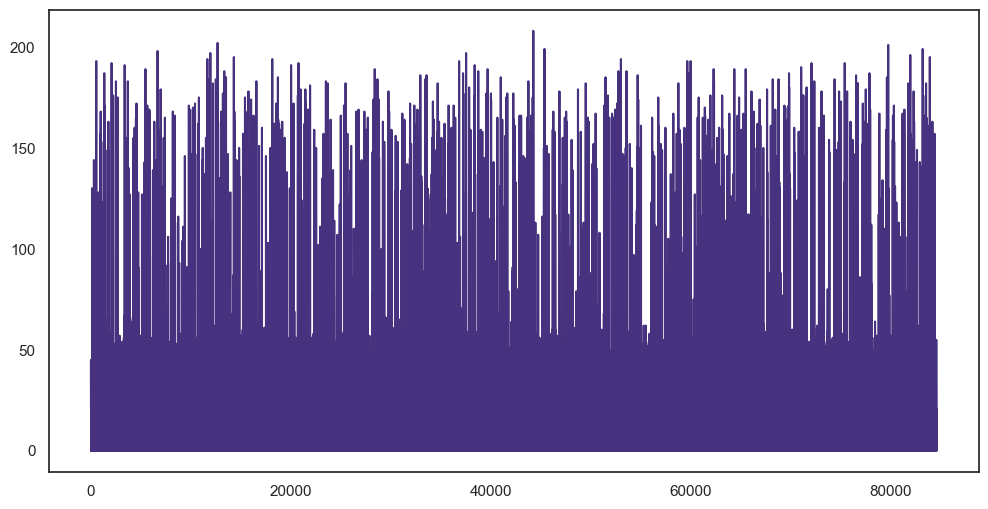

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(eda_df["Unnamed: 0"], eda_df["NoEmp"])
plt.show()

0 State
1 BankState
2 City


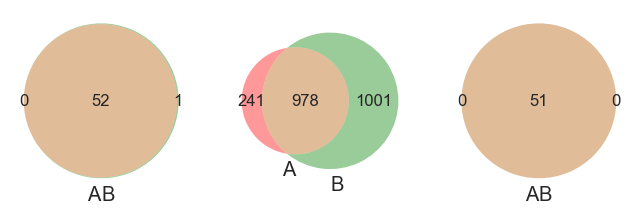

In [38]:
list01= ["State","BankState","City"]
fig,ax = plt.subplots(1,3,figsize=(8,8))
ax.flatten()
for i,c in enumerate(list01):
    print(i,c)
    venn2([set(eda_df[eda_df["UrbanRural"]==2][f"{c}"].unique()), set(eda_df[eda_df["UrbanRural"]==1][f"{c}"].unique())],ax=ax[i-1])
    

0 State
1 BankState
2 City


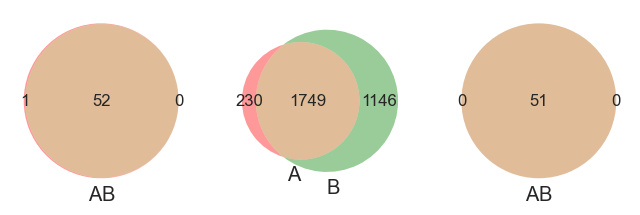

In [39]:
list01= ["State","BankState","City"]
fig,ax = plt.subplots(1,3,figsize=(8,8))
ax.flatten()
for i,c in enumerate(list01):
    print(i,c)
    venn2([set(eda_df[eda_df["UrbanRural"]==1][f"{c}"].unique()), set(eda_df[eda_df["UrbanRural"]==0][f"{c}"].unique())],ax=ax[i-1])
    

0 State
1 BankState
2 City


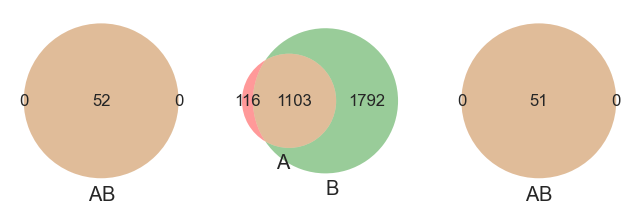

In [40]:
list01= ["State","BankState","City"]
fig,ax = plt.subplots(1,3,figsize=(8,8))
ax.flatten()
for i,c in enumerate(list01):
    print(i,c)
    venn2([set(eda_df[eda_df["UrbanRural"]==2][f"{c}"].unique()), set(eda_df[eda_df["UrbanRural"]==0][f"{c}"].unique())],ax=ax[i-1])
    

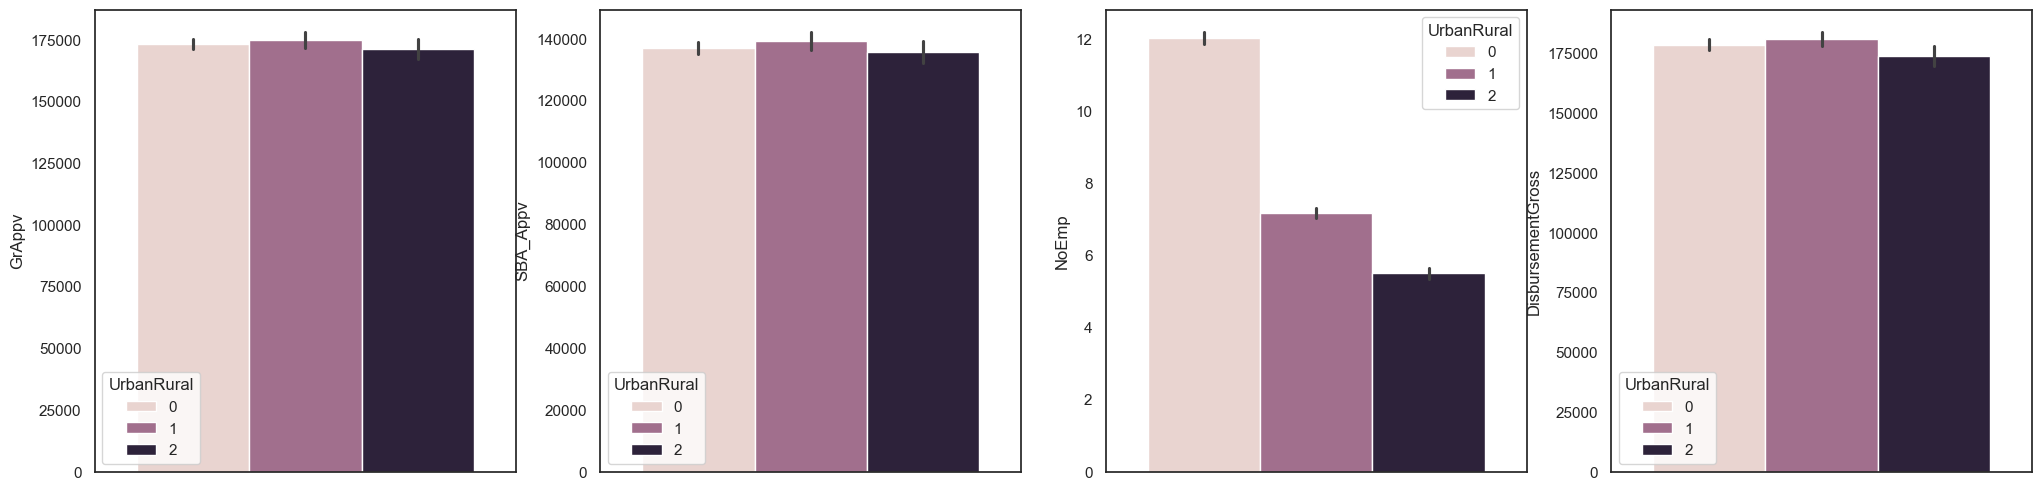

In [41]:
list_02 = ["DisbursementGross","GrAppv","SBA_Appv","NoEmp"]
fig,ax = plt.subplots(1,len(list_02),figsize=(25,6))
ax.flatten()
for i,c in enumerate(list_02):
    sns.barplot(data=eda_df, y=f"{c}",ax=ax[i-1],hue="UrbanRural")

In [56]:
eda_df_rural = eda_df[eda_df["UrbanRural"]==0]
eda_df_rural.reset_index(drop=True,inplace=True)
eda_df_urban = eda_df[eda_df["UrbanRural"]==1]
eda_df_urban.reset_index(inplace=True,drop=True)
eda_df_med = eda_df[eda_df["UrbanRural"]==2]
eda_df_med.reset_index(inplace=True,drop=True)


In [71]:
for c in [eda_df_rural,eda_df_urban,eda_df_med]:
    c["MIS_Status_Ratio"] = len(c[c["MIS_Status"]==1])/len(c[c["MIS_Status"]==0])
    print(c["MIS_Status"].value_counts())
    print(c["MIS_Status_Ratio"].unique())

MIS_Status
1.0    22721
0.0     1316
Name: count, dtype: int64
[17.26519757]
MIS_Status
1.0    9698
0.0    2061
Name: count, dtype: int64
[4.70548278]
MIS_Status
1.0    5348
0.0    1163
Name: count, dtype: int64
[4.59845228]


In [68]:
eda_df_med

,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,train_data,RevLineCr_label,LowDoc_label,City_label,State_label,BankState_label,NoEmp_label,main_key_NoEmp_label,main_key_State,main_key_City,DisbursementGross_main_key_NoEmp_label_med,DisbursementGross_main_key_NoEmp_label_diff,GrAppv_main_key_NoEmp_label_med,GrAppv_main_key_NoEmp_label_diff,SBA_Appv_main_key_NoEmp_label_med,SBA_Appv_main_key_NoEmp_label_diff,CreateJob_main_key_NoEmp_label_med,CreateJob_main_key_NoEmp_label_diff,RetainedJob_main_key_NoEmp_label_med,RetainedJob_main_key_NoEmp_label_diff,NoEmp_main_key_NoEmp_label_med,NoEmp_main_key_NoEmp_label_diff,DisbursementGross_main_key_State_med,DisbursementGross_main_key_State_diff,GrAppv_main_key_State_med,GrAppv_main_key_State_diff,SBA_Appv_main_key_State_med,SBA_Appv_main_key_State_diff,CreateJob_main_key_State_med,CreateJob_main_key_State_diff,RetainedJob_main_key_State_med,RetainedJob_main_key_State_diff,NoEmp_main_key_State_med,NoEmp_main_key_State_diff,DisbursementGross_main_key_City_med,DisbursementGross_main_key_City_diff,GrAppv_main_key_City_med,GrAppv_main_key_City_diff,SBA_Appv_main_key_City_med,SBA_Appv_main_key_City_diff,CreateJob_main_key_City_med,CreateJob_main_key_City_diff,RetainedJob_main_key_City_med,RetainedJob_main_key_City_diff,NoEmp_main_key_City_med,NoEmp_main_key_City_diff,MIS_Status_Ratio
0,9,25,1,1.0,0,0,1,N,N,2007-04-30,1.0,0,2004-03-23,2004,MESA,AZ,AZ,50000,50000,25000,2,1,1,3,1762,3,3,1,1_0,AZ_0,MESA_0,80000.0,-30000.0,80000.0,-30000.0,68000.0,-43000.0,0.0,0.0,0.0,0.0,1.0,0.0,80000.0,-30000.0,80000.0,-30000.0,68000.0,-43000.0,0.0,0.0,0.0,0.0,6.0,-5.0,65000.0,-15000.0,65000.0,-15000.0,58500.0,-33500.0,0.0,0.0,0.0,0.0,4.0,-3.0,4.598452
1,12,56,0,2.0,1,1,57300,Y,NaN,2006-01-31,0.0,61,2003-06-06,2003,NORTH SALT LAKE,UT,UT,100000,100000,50000,2,1,3,6,2006,44,45,1,1_61,XX,XX,80000.0,20000.0,80000.0,20000.0,60000.0,-10000.0,0.0,1.0,0.0,1.0,1.0,-1.0,99000.0,1000.0,83000.0,17000.0,57600.0,-7600.0,0.0,1.0,0.0,1.0,4.0,-4.0,99000.0,1000.0,84000.0,16000.0,58500.0,-8500.0,0.0,1.0,0.0,1.0,4.0,-4.0,4.598452
2,15,82,0,2.0,0,0,1,0,Y,1995-10-31,1.0,23,2000-05-16,2000,GILLETTE,WY,WY,5000,5000,2500,2,1,0,5,1071,50,51,1,1_23,WY_23,GILLETTE_23,65000.0,-60000.0,60000.0,-55000.0,42500.0,-40000.0,0.0,0.0,1.0,-1.0,1.0,-1.0,70000.0,-65000.0,70000.0,-65000.0,56000.0,-53500.0,0.0,0.0,0.0,0.0,3.0,-3.0,70000.0,-65000.0,70000.0,-65000.0,56000.0,-53500.0,0.0,0.0,0.0,0.0,3.0,-3.0,4.598452
3,25,40,4,1.0,3,3,0,N,N,2003-10-31,1.0,45,1996-03-21,1996,WEST ALLIS,WI,OH,210000,210000,157500,2,1,1,3,3034,48,35,2,2_45,XX,XX,120000.0,90000.0,111400.0,98600.0,90000.0,67500.0,0.0,3.0,0.0,3.0,3.0,1.0,99000.0,111000.0,83000.0,127000.0,57600.0,99900.0,0.0,3.0,0.0,3.0,4.0,0.0,99000.0,111000.0,84000.0,126000.0,58500.0,99000.0,0.0,3.0,0.0,3.0,4.0,0.0,4.598452
4,32,81,3,2.0,0,0,1,N,Y,2004-07-31,1.0,23,2005-05-06,2005,AKRON,OH,OH,25000,25000,20000,2,1,1,5,12,35,35,2,2_23,OH_23,XX,84717.0,-59717.0,80000.0,-55000.0,58400.0,-38400.0,0.0,0.0,0.0,0.0,3.0,0.0,101485.0,-76485.0,100000.0,-75000.0,82500.0,-62500.0,0.0,0.0,0.0,0.0,3.0,0.0,99000.0,-74000.0,84000.0,-59000.0,58500.0,-38500.0,0.0,0.0,0.0,0.0,4.0,-1.0,4.598452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12962,84563,82,1,2.0,0,1,1,Y,N,1997-09-30,NaN,23,2007-05-10,2007,ESCONDIDO,CA,CA,414000,414000,414000,2,0,3,3,884,4,4,1,1_23,CA_23,ESCONDIDO_23,65000.0,349000.0,60000.0,354000.0,42500.0,371500.0,0.0,0.0,1.0,0.0,1.0,0.0,70000.0,344000.0,70000.0,344000.0,48000.0,366000.0,0.0,0.0,0.0,1.0,3.0,-2.0,90000.0,324000.0,90000.0,324000.0,72000.0,342000.0,0.0,0.0,0.0,1.0,3.0,-2.0,4.598452
12963,84564,60,1,2.0,0,0,0,Y,S,200

In [70]:
for c in [eda_df_rural,eda_df_urban,eda_df_med]:
    print(c[c["main_key_City"]=="XX"]["main_key_City"].count())

32720
20571
10706


In [57]:
print(eda_df_rural["MIS_Status"].value_counts())
print(eda_df_urban["MIS_Status"].value_counts())
print(eda_df_med["MIS_Status"].value_counts())

MIS_Status
1.0    22721
0.0     1316
Name: count, dtype: int64
MIS_Status
1.0    9698
0.0    2061
Name: count, dtype: int64
MIS_Status
1.0    5348
0.0    1163
Name: count, dtype: int64


MIS_Status
1.0    37767
0.0     4540
Name: count, dtype: int64

In [55]:
eda_df_urban["MIS_Status"].value_counts()

MIS_Status
1.0    9698
0.0    2061
Name: count, dtype: int64

In [47]:
eda_df_rural.describe()

,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,train_data,RevLineCr_label,LowDoc_label,City_label,State_label,BankState_label,NoEmp_label,DisbursementGross_main_key_NoEmp_label_med,DisbursementGross_main_key_NoEmp_label_diff,GrAppv_main_key_NoEmp_label_med,GrAppv_main_key_NoEmp_label_diff,SBA_Appv_main_key_NoEmp_label_med,SBA_Appv_main_key_NoEmp_label_diff,CreateJob_main_key_NoEmp_label_med,CreateJob_main_key_NoEmp_label_diff,RetainedJob_main_key_NoEmp_label_med,RetainedJob_main_key_NoEmp_label_diff,NoEmp_main_key_NoEmp_label_med,NoEmp_main_key_NoEmp_label_diff,DisbursementGross_main_key_State_med,DisbursementGross_main_key_State_diff,GrAppv_main_key_State_med,GrAppv_main_key_State_diff,SBA_Appv_main_key_State_med,SBA_Appv_main_key_State_diff,CreateJob_main_key_State_med,CreateJob_main_key_State_diff,RetainedJob_main_key_State_med,RetainedJob_main_key_State_diff,NoEmp_main_key_State_med,NoEmp_main_key_State_diff,DisbursementGross_main_key_City_med,DisbursementGross_main_key_City_diff,GrAppv_main_key_City_med,GrAppv_main_key_City_diff,SBA_Appv_main_key_City_med,SBA_Appv_main_key_City_diff,CreateJob_main_key_City_med,CreateJob_main_key_City_diff,RetainedJob_main_key_City_med,RetainedJob_main_key_City_diff,NoEmp_main_key_City_med,NoEmp_main_key_City_diff
count,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48293,24037.000000,48381.000000,48381,48381.000000,4.838100e+04,4.838100e+04,4.838100e+04,48381.0,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,4.838100e+04,48381.000000,4.838100e+04,48381.000000,4.838100e+04,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,4.838100e+04,48381.000000,4.838100e+04,48381.000000,4.838100e+04,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,4.838100e+04,48381.000000,4.838100e+04,48381.000000,4.838100e+04,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000,48381.000000
mean,42446.428825,123.569294,12.041049,1.165954,1.977470,2.864203,1604.726463,2001-03-22 09:34:24.820988416,0.945251,27.318100,2001-09-13 14:08:39.228622720,2001.470639,1.786996e+05,1.734223e+05,1.368961e+05,0.0,0.496827,1.176557,3.121287,1572.663504,25.428846,26.292636,2.607181,95982.175937,8.271741e+04,88456.230194,8.496606e+04,66275.326636,7.062078e+04,0.025764,1.951706,0.195221,2.668982,8.092753,3.948296,96656.197784,8.204339e+04,87694.493014,8.572780e+04,65186.221554,7.170988e+04,0.031810,1.945660,0.176650,2.687553,4.184783,7.856266,99967.893832,7.873169e+04,89527.025072,8.389527e+04,65846.800397,7.104930e+04,0.053399,1.924071,0.086604,2.777599,4.016070,8.024979
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1977-06-14 00:00:00,0.000000,0.000000,1977-03-11 00:00:00,1974.000000,4.000000e+03,2.000000e+03,1.000000e+03,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19628.500000,-1.570000e+05,16000.000000,-1.310000e+05,10550.000000,-1.085000e+05,0.000000,-3.000000,0.000000,-8.000000,1.000000,-15.500000,25014.000000,-1.960000e+05,20000.000000,-1.960000e+05,13600.000000,-1.366000e+05,0.000000,-3.000000,0.000000,-6.000000,2.000000,-12.000000,17000.000000,-3.309080e+05,17000.000000,-3.275000e+05,12500.000000,-3.010000e+05,0.000000,-8.500000,0.000000,-9.000000,1.000000,-14.000000
25%,21303.000000,58.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1996-07-31 00:00:00,1.000000,0.000000,1997-08-05 00:00:00,1997.000000,4.762100e+04,4.000000e+04,2.500000e+04,0.0,0.000000,1.000000,3.000000,832.000000,9.000000,13.000000,2.000000,80000.000000,-4.981450e+04,80000.000000,-4.600000e+04,58100.000000,-3.750000e+04,0.000000,0.000000,0.000000,0.000000,3.000000,-1.000000,87300.000000,-5.000000e+04,80000.000000,-4.500000e+04,57600.000000,-3.600000e+04,0.000000,0.000000,0.000000,0.000000,4.000000,

# Create Model

In [63]:
train_df.columns

Index(['ID', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'RevLineCr', 'LowDoc', 'DisbursementDate',
       'MIS_Status', 'Sector', 'ApprovalDate', 'ApprovalFY', 'City', 'State',
       'BankState', 'DisbursementGross', 'GrAppv', 'SBA_Appv', 'UrbanRural',
       'RevLineCr_label', 'LowDoc_label', 'City_label', 'State_label',
       'BankState_label', 'NoEmp_label', 'main_key_NoEmp_label',
       'main_key_State', 'main_key_City',
       'DisbursementGross_main_key_NoEmp_label_med',
       'DisbursementGross_main_key_NoEmp_label_diff',
       'GrAppv_main_key_NoEmp_label_med', 'GrAppv_main_key_NoEmp_label_diff',
       'SBA_Appv_main_key_NoEmp_label_med',
       'SBA_Appv_main_key_NoEmp_label_diff',
       'CreateJob_main_key_NoEmp_label_med',
       'CreateJob_main_key_NoEmp_label_diff',
       'RetainedJob_main_key_NoEmp_label_med',
       'RetainedJob_main_key_NoEmp_label_diff',
       'NoEmp_main_key_NoEmp_label_med', 'NoEmp_main_key_NoEmp_label_d

In [64]:
drop_list = list(train_df.select_dtypes("object").columns)
drop_list.extend(train_df.select_dtypes("datetime").columns)
drop_list

['RevLineCr',
 'LowDoc',
 'City',
 'State',
 'BankState',
 'main_key_NoEmp_label',
 'main_key_State',
 'main_key_City',
 'DisbursementDate',
 'ApprovalDate']

In [65]:
target_encode_list = ["State","BankState"]
for c in target_encode_list:
    drop_list.remove(c)

In [66]:
drop_list

['RevLineCr',
 'LowDoc',
 'City',
 'main_key_NoEmp_label',
 'main_key_State',
 'main_key_City',
 'DisbursementDate',
 'ApprovalDate']

In [67]:
drop_list_other = ["ID","State_label","BankState_label","MIS_Status"]
[drop_list.append(c) for c in drop_list_other]

[None, None, None, None]

In [68]:
drop_list

['RevLineCr',
 'LowDoc',
 'City',
 'main_key_NoEmp_label',
 'main_key_State',
 'main_key_City',
 'DisbursementDate',
 'ApprovalDate',
 'ID',
 'State_label',
 'BankState_label',
 'MIS_Status']

In [69]:
from sklearn.metrics import log_loss
##
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)
##
def objective(train_x,train_y,test_x,test_y,valid_index,train_df,trial):
        d_train=lgb.Dataset(train_x,label=train_y)
        d_valid=lgb.Dataset(test_x,label=test_y)
        param = {
        'objective': 'binary',#trial.suggest_categorical("objective",['binary', 'tweedie']),'num_class': 3
        'metric': 'binary_logloss',
        'learning_rate': 0.003,#trial.suggest_loguniform('learning_rate',0.006),
        'boosting':'gbdt',
#         'is_unbalance':True,
#         'scale_pos_weight':trial.suggest_loguniform('scale_pos_weight', 1,5),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'max_depth':trial.suggest_int('max_depth', 1, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
        'early_stopping_rounds':500,
        'seed':1,'verbose' : -1,'num_boost_round':100000,
        'tree_learner':trial.suggest_categorical("tree_learner",['serial', 'feature', 'data', 'voting']),
        # 'data_sample_strategy':trial.suggest_categorical("data_sample_strategy",['goss', 'bagging'])
    }
 
        gbm = lgb.train(param,d_train,valid_sets = [d_train, d_valid],callbacks=[lgb.early_stopping(stopping_rounds=500, verbose=True), lgb.log_evaluation(300)])
        preds = gbm.predict(test_x)
        
#         oof_predictions = np.zeros([len(train_df),2])
#         oof_predictions[valid_index]=preds
#         y_true=np.zeros([len(test_y),3])
#         y_true[:, 0]=np.where(test_y==0,1,0)
#         y_true[:, 1]=np.where(test_y==1,1,0)
#         y_true[:, 2]=np.where(test_y==2,1,0)
#         print(gbm.predict(test_x))
#         print(preds[:,0])
#         print(y_true[:,0])
#         print(preds.shape)
        score=log_loss(test_y,preds)
#         score=log_loss(test_y,preds)
        return score

In [70]:
train_df

,ID,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,RevLineCr_label,LowDoc_label,City_label,State_label,BankState_label,NoEmp_label,main_key_NoEmp_label,main_key_State,main_key_City,DisbursementGross_main_key_NoEmp_label_med,DisbursementGross_main_key_NoEmp_label_diff,GrAppv_main_key_NoEmp_label_med,GrAppv_main_key_NoEmp_label_diff,SBA_Appv_main_key_NoEmp_label_med,SBA_Appv_main_key_NoEmp_label_diff,CreateJob_main_key_NoEmp_label_med,CreateJob_main_key_NoEmp_label_diff,RetainedJob_main_key_NoEmp_label_med,RetainedJob_main_key_NoEmp_label_diff,NoEmp_main_key_NoEmp_label_med,NoEmp_main_key_NoEmp_label_diff,DisbursementGross_main_key_State_med,DisbursementGross_main_key_State_diff,GrAppv_main_key_State_med,GrAppv_main_key_State_diff,SBA_Appv_main_key_State_med,SBA_Appv_main_key_State_diff,CreateJob_main_key_State_med,CreateJob_main_key_State_diff,RetainedJob_main_key_State_med,RetainedJob_main_key_State_diff,NoEmp_main_key_State_med,NoEmp_main_key_State_diff,DisbursementGross_main_key_City_med,DisbursementGross_main_key_City_diff,GrAppv_main_key_City_med,GrAppv_main_key_City_diff,SBA_Appv_main_key_City_med,SBA_Appv_main_key_City_diff,CreateJob_main_key_City_med,CreateJob_main_key_City_diff,RetainedJob_main_key_City_med,RetainedJob_main_key_City_diff,NoEmp_main_key_City_med,NoEmp_main_key_City_diff,svd_City_truncatedsvd0,svd_City_truncatedsvd1,svd_City_truncatedsvd2,svd_City_truncatedsvd3,svd_City_truncatedsvd4,svd_City_truncatedsvd5,svd_City_truncatedsvd6,svd_City_truncatedsvd7,svd_City_truncatedsvd8,svd_City_truncatedsvd9,svd_City_truncatedsvd10,svd_City_truncatedsvd11,svd_City_truncatedsvd12,svd_City_truncatedsvd13,svd_City_truncatedsvd14,svd_City_truncatedsvd15,svd_City_truncatedsvd16,nmf_City_nmf0,nmf_City_nmf1,nmf_City_nmf2,nmf_City_nmf3,nmf_City_nmf4,nmf_City_nmf5,nmf_City_nmf6,nmf_City_nmf7,nmf_City_nmf8,nmf_City_nmf9,nmf_City_nmf10,nmf_City_nmf11,nmf_City_nmf12,nmf_City_nmf13,nmf_City_nmf14,nmf_City_nmf15,nmf_City_nmf16
0,0,163,21,1.0,0,0,1,N,N,1998-01-31,1,0,2006-09-22,2006,PHOENIX,AZ,SD,80000,80000,68000,0,1,3,1857,3,41,4,4_0,AZ_0,PHOENIX_0,100000.0,-20000.0,100000.0,-20000.0,82500.0,-14500.0,0.0,0.0,0.0,0.0,19.0,2.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,7.0,14.0,80000.0,0.0,80000.0,0.0,68000.0,0.0,0.0,0.0,0.0,0.0,10.0,11.0,1.237041,0.774666,-0.790986,-1.940700,1.061481,-0.358730,0.186792,-1.300819,1.683088,-2.209036,0.856589,-0.701709,-1.534264,-0.534186,-0.426118,-0.347151,1.842108,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,4.592016e-19,0.0,3.620079e-19,0.0,0.000000,0.0,0.0,0.0,0.523391
1,1,84,6,1.0,4,0,0,0,N,1993-10-31,1,62,1992-06-30,1992,MCALESTER,OK,OK,287000,287000,229600,0,0,3,1451,36,36,3,3_62,XX,XX,121000.0,166000.0,100000.0,187000.0,80000.0,149600.0,0.0,4.0,0.0,0.0,6.0,0.0,99000.0,188000.0,82500.0,204500.0,56270.0,173330.0,0.0,4.0,0.0,0.0,4.0,2.0,100000.0,187000.0,85000.0,202000.0,59500.0,170100.0,0.0,4.0,0.0,0.0,4.0,2.0,-1.270709,-0.006407,0.002430,0.000934,0.000142,0.000363,-0.000265,0.001184,0.000723,0.000629,0.000655,-0.001871,-0.001692,0.000734,0.000012,-0.000391,-0.000181,0.499588,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000
2,2,242,45,1.0,4,90,0,N,N,2001-08-31,1,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983,30000,15000,1,1,3,1021,31,31,4,4_42,NJ_42,XX,121050.0,-89067.0,100000.0,-70000.0,65600.0,-50600.0,0.0,4.0,0.0,90.0,18.0,27.0,110000.0,-78017.0,100000.0,-70000.0,76500.0,-61500.0,0.0,4.0,0.0,90.0,12.0,33.0,100000.0,-68017.0,85000.0,-55000.0,59500.0,-44500.0,0.0,4.0,0.0,90.0,4.0,41.0,-1.270709,-0.006407,0.002430,0.000934,0.000142,0.000363,-0.000265,0.001184,0.000723,0.000629,0.000655,-0.001871,-0.001692,0.000734,0.000012,-0.000391,-0.000181,0.499588,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0

In [71]:
target_encode_list = ["State","BankState"]

In [72]:
train_df["DisbursementGross"].dtypes

dtype('int32')

In [73]:
train_df["MIS_Status"]

0        1
1        1
2        1
3        1
4        1
        ..
42302    1
42303    1
42304    1
42305    1
42306    1
Name: MIS_Status, Length: 42307, dtype: int64

In [74]:
features=[c for c in train_df.columns if c not in drop_list]
# if CFG.model=='lgb':
import lightgbm as lgb
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import KFold
importance_df=pd.DataFrame(index=train_df[features].columns)
importance_df['importance']=0
fold=5
predictions=pd.DataFrame()
predict=np.zeros([len(test_df),])
oof_predictions = np.zeros([len(train_df),])
# Target Encoding for state and bank state test data  
for c in target_encode_list:
    tmp_df = pd.DataFrame({c:train_df[c],f"target_{c}":train_df["MIS_Status"]}) 
    target_mean = tmp_df.groupby(c)[f"target_{c}"].mean()
    test_df.loc[:,c] = test_df[c].map(target_mean)
    test_df[c] = test_df[c].astype(float)
    
for seeds in[1]:
    fold=5
    skf=MultilabelStratifiedKFold(n_splits=5,random_state=seeds,shuffle=True)
    selected=features.copy()
        
    for i ,(tr_index,va_index) in enumerate(skf.split(train_df,train_df[['MIS_Status','Sector','State','UrbanRural']])):


        tr_x,tr_y=train_df[selected].iloc[tr_index],train_df['MIS_Status'].iloc[tr_index]
        va_x,va_y=train_df[selected].iloc[va_index],train_df['MIS_Status'].iloc[va_index]

        # Target Encoding for state and bank state 
        for c in target_encode_list:
            tmp_df = pd.DataFrame({c:tr_x[c],f"target_{c}":tr_y}) 
            target_mean = tmp_df.groupby(c)[f"target_{c}"].mean()
            va_x.loc[:,c] = va_x[c].map(target_mean)

            tmp = np.repeat(np.nan, tr_x.shape[0])
            kf_encoding = KFold(n_splits=4, shuffle =True,random_state=seeds)

            for idx_1,idx_2 in kf_encoding.split(tr_x):
                target_mean = tmp_df.iloc[idx_1].groupby(c)[f"target_{c}"].mean()
                tmp[idx_2] = tr_x[c].iloc[idx_2].map(target_mean)
            tr_x.loc[:,c]=tmp

            tr_x[c] = tr_x[c].astype(float)
            va_x[c] = va_x[c].astype(float)
        d_train_df=lgb.Dataset(tr_x,label=tr_y)

        d_valid=lgb.Dataset(va_x,label=va_y)
        if CFG.train==False:
            param = {'objective': 'binary','metric': 'binary_logloss','learning_rate': 0.003,'boosting':'gbdt','scale_pos_weight': 1, 'lambda_l1': 1.8657458525452022, 'lambda_l2': 0.0043319561423214945, 'num_leaves': 20, 'feature_fraction': 0.23875565259514844, 'bagging_fraction': 0.7939326324321189, 'bagging_freq': 2, 'min_child_samples': 73, 'tree_learner': 'feature','early_stopping_rounds':500,
             'seed':seeds,'random_state':seeds,'data_random_seed':seeds,'feature_fraction_seed':seeds,'random_seed':seeds,'verbose' : -1,'num_boost_round':100000}

            gbm = lgb.train(param, d_train_df,valid_sets = [d_train_df, d_valid],callbacks=[lgb.early_stopping(stopping_rounds=500, verbose=True), lgb.log_evaluation(100)])
            preds=gbm.predict(va_x[selected])
            predict += gbm.predict(test_df[selected])/5
            oof_predictions[va_index]=preds
            importance_df['importance']+=gbm.feature_importance(importance_type='gain')/5
        else:
            if i==0:
                print(CFG.train)
                optuna.logging.set_verbosity(optuna.logging.INFO)
                study = optuna.create_study(direction='minimize')
                study.optimize(functools.partial(objective,tr_x,tr_y,va_x,va_y,va_index,train_df),timeout=60*60*3)#n_trials = 1000)
                print('Number of finished trials:', len(study.trials))
                print('Best trial:', study.best_trial.params)

C:\Users\kaminogo.kenji\AppData\Local\miniconda3\envs\venv_tabledata_001\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 500 rounds
[100]	training's binary_logloss: 0.319425	valid_1's binary_logloss: 0.321255
[200]	training's binary_logloss: 0.306678	valid_1's binary_logloss: 0.309492
[300]	training's binary_logloss: 0.297974	valid_1's binary_logloss: 0.30159
[400]	training's binary_logloss: 0.291843	valid_1's binary_logloss: 0.296283
[500]	training's binary_logloss: 0.287193	valid_1's binary_logloss: 0.292422
[600]	training's binary_logloss: 0.2837	valid_1's binary_logloss: 0.289664
[700]	training's binary_logloss: 0.280799	valid_1's binary_logloss: 0.287479
[800]	training's binary_logloss: 0.278301	valid_1's binary_logloss: 0.285677
[900]	training's binary_logloss: 0.276123	valid_1's binary_logloss: 0.284214
[1000]	training's binary_logloss: 0.274334	valid_1's binary_logloss: 0.283112
[1100]	training's binary_logloss: 0.272676	valid_1's binary_logloss: 0.282225
[1200]	training's binary_logloss: 0.271187	valid_1's binary_logloss: 0.281505
[1300]	trainin

C:\Users\kaminogo.kenji\AppData\Local\miniconda3\envs\venv_tabledata_001\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 500 rounds
[100]	training's binary_logloss: 0.31981	valid_1's binary_logloss: 0.319302
[200]	training's binary_logloss: 0.307203	valid_1's binary_logloss: 0.306857
[300]	training's binary_logloss: 0.298617	valid_1's binary_logloss: 0.298661
[400]	training's binary_logloss: 0.292511	valid_1's binary_logloss: 0.292989
[500]	training's binary_logloss: 0.287941	valid_1's binary_logloss: 0.2889
[600]	training's binary_logloss: 0.284467	valid_1's binary_logloss: 0.286031
[700]	training's binary_logloss: 0.281616	valid_1's binary_logloss: 0.283834
[800]	training's binary_logloss: 0.279116	valid_1's binary_logloss: 0.281917
[900]	training's binary_logloss: 0.276893	valid_1's binary_logloss: 0.280332
[1000]	training's binary_logloss: 0.275087	valid_1's binary_logloss: 0.27926
[1100]	training's binary_logloss: 0.273434	valid_1's binary_logloss: 0.278348
[1200]	training's binary_logloss: 0.271935	valid_1's binary_logloss: 0.277574
[1300]	training

C:\Users\kaminogo.kenji\AppData\Local\miniconda3\envs\venv_tabledata_001\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 500 rounds
[100]	training's binary_logloss: 0.318915	valid_1's binary_logloss: 0.32134
[200]	training's binary_logloss: 0.305884	valid_1's binary_logloss: 0.310275
[300]	training's binary_logloss: 0.296902	valid_1's binary_logloss: 0.303017
[400]	training's binary_logloss: 0.290544	valid_1's binary_logloss: 0.298166
[500]	training's binary_logloss: 0.285778	valid_1's binary_logloss: 0.294732
[600]	training's binary_logloss: 0.28221	valid_1's binary_logloss: 0.292416
[700]	training's binary_logloss: 0.279296	valid_1's binary_logloss: 0.290725
[800]	training's binary_logloss: 0.276721	valid_1's binary_logloss: 0.289339
[900]	training's binary_logloss: 0.274484	valid_1's binary_logloss: 0.288274
[1000]	training's binary_logloss: 0.272628	valid_1's binary_logloss: 0.287541
[1100]	training's binary_logloss: 0.27093	valid_1's binary_logloss: 0.286927
[1200]	training's binary_logloss: 0.269417	valid_1's binary_logloss: 0.28645
[1300]	training

C:\Users\kaminogo.kenji\AppData\Local\miniconda3\envs\venv_tabledata_001\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 500 rounds
[100]	training's binary_logloss: 0.319315	valid_1's binary_logloss: 0.32091
[200]	training's binary_logloss: 0.306436	valid_1's binary_logloss: 0.3092
[300]	training's binary_logloss: 0.297654	valid_1's binary_logloss: 0.301463
[400]	training's binary_logloss: 0.291488	valid_1's binary_logloss: 0.296141
[500]	training's binary_logloss: 0.286863	valid_1's binary_logloss: 0.292385
[600]	training's binary_logloss: 0.28338	valid_1's binary_logloss: 0.289727
[700]	training's binary_logloss: 0.280483	valid_1's binary_logloss: 0.287608
[800]	training's binary_logloss: 0.277949	valid_1's binary_logloss: 0.285936
[900]	training's binary_logloss: 0.275753	valid_1's binary_logloss: 0.284594
[1000]	training's binary_logloss: 0.273951	valid_1's binary_logloss: 0.283647
[1100]	training's binary_logloss: 0.272308	valid_1's binary_logloss: 0.282787
[1200]	training's binary_logloss: 0.270822	valid_1's binary_logloss: 0.282138
[1300]	training

C:\Users\kaminogo.kenji\AppData\Local\miniconda3\envs\venv_tabledata_001\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 500 rounds
[100]	training's binary_logloss: 0.31957	valid_1's binary_logloss: 0.320303
[200]	training's binary_logloss: 0.3069	valid_1's binary_logloss: 0.308056
[300]	training's binary_logloss: 0.298255	valid_1's binary_logloss: 0.299834
[400]	training's binary_logloss: 0.292119	valid_1's binary_logloss: 0.29413
[500]	training's binary_logloss: 0.28752	valid_1's binary_logloss: 0.290144
[600]	training's binary_logloss: 0.28405	valid_1's binary_logloss: 0.287279
[700]	training's binary_logloss: 0.281206	valid_1's binary_logloss: 0.285045
[800]	training's binary_logloss: 0.278665	valid_1's binary_logloss: 0.283192
[900]	training's binary_logloss: 0.276456	valid_1's binary_logloss: 0.281682
[1000]	training's binary_logloss: 0.274649	valid_1's binary_logloss: 0.280599
[1100]	training's binary_logloss: 0.272987	valid_1's binary_logloss: 0.279708
[1200]	training's binary_logloss: 0.27148	valid_1's binary_logloss: 0.27896
[1300]	training's b

In [77]:
importance_df.sort_values('importance',ascending=False).to_csv(f'importance_baseline_{CFG.ver}.csv')

In [85]:
oof_predictions

array([0.98278731, 0.9596817 , 0.97077445, ..., 0.93702945, 0.97641222,
       0.94820589])

In [87]:
oof=pd.DataFrame(oof_predictions)
oof.rename(columns={0:'prob1'},inplace=True)
oof['True']=train['MIS_Status']

# Value Metrics

In [88]:
oof

,prob1,True
0,0.982787,1
1,0.959682,1
2,0.970774,1
3,0.962944,1
4,0.941949,1
...,...,...
42302,0.983902,1
42303,0.932100,1
42304,0.937029,1
42305,0.976412,1


In [90]:
from sklearn.metrics import f1_score

pd.set_option('display.max_rows', None)
score_list = [{"Thresh":"Score"}]
for thresh in[0.6,0.7,0.74,0.745,0.746,0.747,0.748,0.749,0.75,0.751,0.752,0.753,0.754,0.755,0.76,0.761,0.762,0.763,0.767,0.768,0.769,0.77,0.771,0.772,0.773,0.774,0.78,0.8,0.9]:
    oof["thresh"] = 0
    oof['thresh']=np.where(oof['prob1']>thresh,1,0)
    print("#######")
    print(thresh)
    print(f1_score(oof['thresh'],oof['True'],average='macro'))
    score =f1_score(oof['thresh'],oof['True'],average='macro')
    score_list.append({f"{thresh}":f"{score}"})
    print("#######")

#######
0.6
0.6551935539028755
#######
#######
0.7
0.6757262545461813
#######
#######
0.74
0.6783457799679364
#######
#######
0.745
0.6783683078111551
#######
#######
0.746
0.6782148012348871
#######
#######
0.747
0.6781746214435039
#######
#######
0.748
0.6782339634584447
#######
#######
0.749
0.67813330563663
#######
#######
0.75
0.67851494246713
#######
#######
0.751
0.6785121418835771
#######
#######
0.752
0.6783978743650534
#######
#######
0.753
0.6782118000788863
#######
#######
0.754
0.6784838173086946
#######
#######
0.755
0.6784023024209216
#######
#######
0.76
0.6775285887773324
#######
#######
0.761
0.6772910897810405
#######
#######
0.762
0.6773512883855957
#######
#######
0.763
0.6773568930550865
#######
#######
0.767
0.6773411835773543
#######
#######
0.768
0.6773383762758138
#######
#######
0.769
0.6772934848114873
#######
#######
0.77
0.6771121884868047
#######
#######
0.771
0.6771441862907119
#######
#######
0.772
0.6772026054334609
#######
#######
0.773
0.677228492323

In [91]:
score_list

[{'0.6': '0.6551935539028755'},
 {'0.7': '0.6757262545461813'},
 {'0.74': '0.6783457799679364'},
 {'0.745': '0.6783683078111551'},
 {'0.746': '0.6782148012348871'},
 {'0.747': '0.6781746214435039'},
 {'0.748': '0.6782339634584447'},
 {'0.749': '0.67813330563663'},
 {'0.75': '0.67851494246713'},
 {'0.751': '0.6785121418835771'},
 {'0.752': '0.6783978743650534'},
 {'0.753': '0.6782118000788863'},
 {'0.754': '0.6784838173086946'},
 {'0.755': '0.6784023024209216'},
 {'0.76': '0.6775285887773324'},
 {'0.761': '0.6772910897810405'},
 {'0.762': '0.6773512883855957'},
 {'0.763': '0.6773568930550865'},
 {'0.767': '0.6773411835773543'},
 {'0.768': '0.6773383762758138'},
 {'0.769': '0.6772934848114873'},
 {'0.77': '0.6771121884868047'},
 {'0.771': '0.6771441862907119'},
 {'0.772': '0.6772026054334609'},
 {'0.773': '0.6772284923231348'},
 {'0.774': '0.6775746472033897'},
 {'0.78': '0.6778180328692816'},
 {'0.8': '0.6735220679837186'},
 {'0.9': '0.5879676461100958'}]

# Create Submission

In [99]:
pred_df=pd.DataFrame(predict)
pred_df=pred_df.add_prefix('col_')
sub=pd.DataFrame(test['Unnamed: 0'].copy())
# sub['predict_2']=0
sub['predict_0']=0
sub['predict_1']=0
sub['predict_1']=np.where(pred_df['col_0']>0.75,1,0)

# # sub['predict_2']=np.where(tmp['col_2']>0.0615,1,0)
# # sub['predict_0']=np.where(tmp['col_0']>0.205,1,0)

In [101]:
sub['predict_1'].value_counts()

predict_1
1    39043
0     3265
Name: count, dtype: int64

In [102]:
sub[['Unnamed: 0','predict_1']].to_csv(f'sub_kaminogo{CFG.ver}.csv',header=False,index=False)

# Other 

In [43]:
population_df= pd.read_csv("../data/us_popluation.csv")

In [23]:
population_df.dtypes

2024          int64
per_2024    float64
2023          int64
2010          int64
State        object
1900          int64
1910          int64
1920          int64
1930          int64
1940          int64
1950          int64
1960          int64
1970          int64
1980          int64
1990          int64
2000          int64
2003          int64
per_2023    float64
per_2010    float64
per_1900    float64
per_1910    float64
per_1920    float64
per_1930    float64
per_1940    float64
per_1950    float64
per_1960    float64
per_1970    float64
per_1980    float64
per_1990    float64
per_2000    float64
per_2003    float64
dtype: object

In [ ]:
population_df